# Binary clustering/feature reduction

In [61]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration, KMeans
import scipy.cluster.hierarchy as sch
import sys, pickle
from classDeclarations import file_data
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import vstack, csr_matrix
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [62]:
with open('gathered_data_distr/sample1/byte_distr_sample_1MB_v1.pkl', "rb") as fp:
    dataset = pickle.load(fp)
print(len(dataset)) # dataset is a list containing three lists of file data(Images, Tabular, and Text data)

6


In [63]:
# Just stacks the file data together for ONE FILE TYPE 
def combine_1gram_data(file_data):
    one_gram_array = np.empty((0, 0))
   
    for data in file_data:
        if one_gram_array.size == 0:
            one_gram_array = data.one_gram_distr
        else:
            one_gram_array = np.vstack((one_gram_array, data.one_gram_distr))
    return one_gram_array

In [64]:
one_gram_img = combine_1gram_data(dataset[0])
one_gram_tabular = combine_1gram_data(dataset[1])
one_gram_freetext = combine_1gram_data(dataset[2])
one_gram_json_xml = combine_1gram_data(dataset[3])
one_gram_netcdf = combine_1gram_data(dataset[4])
one_gram_unknown = combine_1gram_data(dataset[5])

print(one_gram_img.shape)
print(one_gram_tabular.shape)
print(one_gram_freetext.shape)
print(one_gram_json_xml.shape)
print(one_gram_netcdf.shape)
print(one_gram_unknown.shape)

total_dataset_1_gram = np.vstack((one_gram_img, one_gram_tabular, one_gram_freetext, one_gram_json_xml, one_gram_netcdf, one_gram_unknown))
print(total_dataset_1_gram.shape)
print(type(total_dataset_1_gram))
total_dataset_1_gram = np.nan_to_num(total_dataset_1_gram)

(100, 258)
(100, 258)
(100, 258)
(100, 258)
(100, 258)
(100, 258)
(600, 258)
<class 'numpy.ndarray'>


In [65]:
all_file_data = dataset[0] + dataset[1] + dataset[2] + dataset[3] + dataset[4] + dataset[5]
#Input Y: 2-d numpy array with features reduced
#Original file_data to get extractors from
#plot title
def plot_extractors_against_feature_reduction(all_file_data, Y, title):
    no_best_extractor = True
    image_best_extractor = True
    tab_best_extractor = True
    kw_best_extractor = True

    json_xml_best_extractor = True
    netcdf_best_extractor = True


    for i in range(Y.shape[0]):

        if all_file_data[i].best_extractors == 'unknown':
            plt.plot(Y[i][0], Y[i][1], "rx", label="No extractor/unknown" if no_best_extractor else "")
            no_best_extractor = False
        elif all_file_data[i].best_extractors == 'image':
            plt.plot(Y[i][0], Y[i][1], "ro", label="Image best extractor" if image_best_extractor else "")
            image_best_extractor = False
        elif all_file_data[i].best_extractors == 'tabular':
            plt.plot(Y[i][0], Y[i][1], "bo", label="Tabular best extractor" if tab_best_extractor else "")
            tab_best_extractor = False
        elif all_file_data[i].best_extractors == 'freetext':
            plt.plot(Y[i][0], Y[i][1], "go", label="Keyword best extractor" if kw_best_extractor else "")
            kw_best_extractor = False
        elif all_file_data[i].best_extractors == 'json/xml':
            plt.plot(Y[i][0], Y[i][1], "co", label="JSON/XML best extractor" if json_xml_best_extractor else "")
            json_xml_best_extractor = False
        elif all_file_data[i].best_extractors == 'netcdf':
            plt.plot(Y[i][0], Y[i][1], "mo", label="netcdf best extractor" if netcdf_best_extractor else "")
            netcdf_best_extractor = False
    
          
    plt.legend()
    plt.title(title)
    plt.show()

def plot_extractors_against_feature_reduction_3d(all_file_data, Y, title):
    no_best_extractor = True
    image_best_extractor = True
    tab_best_extractor = True
    kw_best_extractor = True

    json_xml_best_extractor = True
    netcdf_best_extractor = True

    
    fig = plt.figure()
    ax = Axes3D(fig)

    for i in range(Y.shape[0]):

        if all_file_data[i].best_extractors == 'unknown':
            ax.plot(Y[i][0], Y[i][1], Y[i][2], "rx", label="No extractor/unknown" if no_best_extractor else "")
            no_best_extractor = False
        elif all_file_data[i].best_extractors == 'image':
            ax.plot(Y[i][0], Y[i][1], Y[i][2], "ro", label="Image best extractor" if image_best_extractor else "")
            image_best_extractor = False
        elif all_file_data[i].best_extractors == 'tabular':
            ax.plot(Y[i][0], Y[i][1], Y[i][2], "bo", label="Tabular best extractor" if tab_best_extractor else "")
            tab_best_extractor = False
        elif all_file_data[i].best_extractors == 'freetext':
            ax.plot(Y[i][0], Y[i][1], Y[i][2], "go", label="Keyword best extractor" if kw_best_extractor else "")
            kw_best_extractor = False
        elif all_file_data[i].best_extractors == 'json/xml':
            ax.plot(Y[i][0], Y[i][1], Y[i][2], "co", label="JSON/XML best extractor" if json_xml_best_extractor else "")
            json_xml_best_extractor = False
        elif all_file_data[i].best_extractors == 'netcdf':
            ax.plot(Y[i][0], Y[i][1], Y[i][2], "mo", label="netcdf best extractor" if netcdf_best_extractor else "")
            netcdf_best_extractor = False
    
          
    plt.legend()
    plt.title(title)
    plt.show()

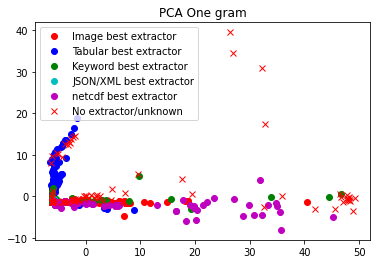

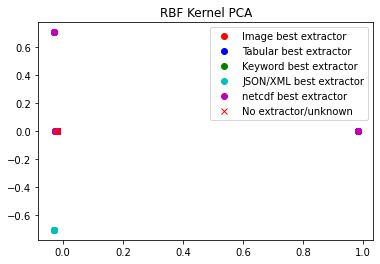

In [66]:
sc_pca = StandardScaler()
pca = PCA(n_components=2)

pca_after_sc = Pipeline([
    ('std_scaler', sc_pca),
    ('pca', pca),
])

onegram_pca = pca_after_sc.fit_transform(total_dataset_1_gram)

sc_kpca = StandardScaler()
kpca = KernelPCA(n_components=2, kernel='rbf', 
                 gamma=15, random_state=42)

kca_after_sc = Pipeline([
    ('std_scaler', sc_kpca),
    ('pca', kpca),
])


onegram_kpca = kpca.fit_transform(total_dataset_1_gram)

plot_extractors_against_feature_reduction(all_file_data, onegram_pca, "PCA One gram")
plot_extractors_against_feature_reduction(all_file_data, onegram_kpca, "RBF Kernel PCA")

In [67]:
print(pca.explained_variance_ratio_)


[0.53168186 0.065626  ]


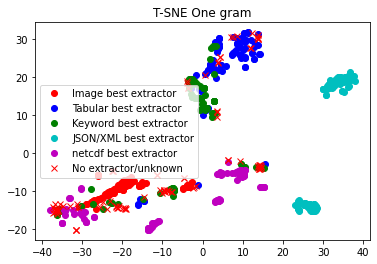

In [68]:
sc = StandardScaler()
pca = PCA(n_components=50)
tsne = TSNE(n_components=2)

tsne_after_pca = Pipeline([
    ('std_scaler', sc),
    ('pca', pca),
    ('tsne', tsne)
])

onegram_tsne = tsne_after_pca.fit_transform(total_dataset_1_gram)
plot_extractors_against_feature_reduction(all_file_data, onegram_tsne, "T-SNE One gram")

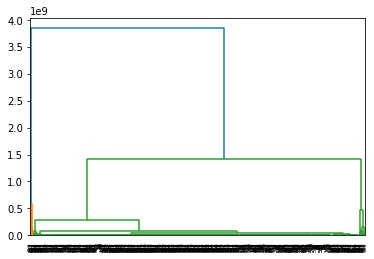

In [69]:
dendrogram = sch.dendrogram(sch.linkage(total_dataset_1_gram, method='ward'))

/tmp/ipykernel_2239498/1604320742.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


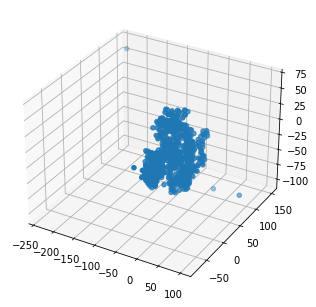

In [70]:
sc = StandardScaler()
pca = PCA(n_components=50)
tsne = TSNE(n_components=3)

tsne_after_pca = Pipeline([
    ('std_scaler', sc),
    ('pca', pca),
    ('tsne', tsne)
])

onegram_tsne = tsne_after_pca.fit_transform(total_dataset_1_gram)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(onegram_tsne[:,0], onegram_tsne[:,1], onegram_tsne[:,2])
plt.show()




/tmp/ipykernel_2239498/4155999399.py:52: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


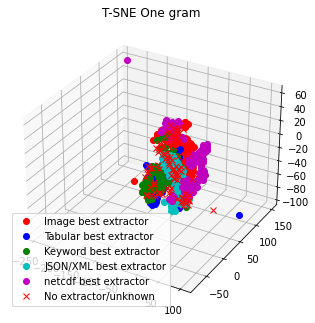

In [71]:
plot_extractors_against_feature_reduction_3d(all_file_data, onegram_tsne, "T-SNE One gram")

### Two Grams


In [72]:
def combine_2gram_data(file_data):
    dict_list = []
    for data in file_data:
            dict_list.append(data.two_gram_distr) 
    
    v = DictVectorizer(sparse=False)
    two_gram_array = v.fit_transform(dict_list)
    return two_gram_array

In [73]:
two_gram_img = combine_2gram_data(dataset[0])
two_gram_tabular = combine_2gram_data(dataset[1])
two_gram_freetext = combine_2gram_data(dataset[2])
two_gram_json_xml = combine_2gram_data(dataset[3])
two_gram_netcdf = combine_2gram_data(dataset[4])
two_gram_unknown = combine_2gram_data(dataset[5])

two_grams_total_dataset = np.vstack((two_gram_img, two_gram_tabular, two_gram_freetext, two_gram_json_xml, two_gram_netcdf, two_gram_unknown))
print(two_grams_total_dataset.shape)
two_grams_total_dataset = np.nan_to_num(two_grams_total_dataset)

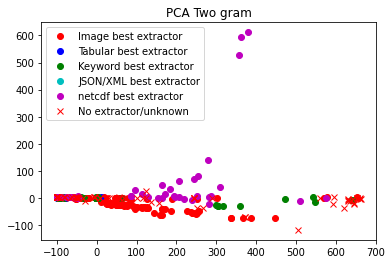

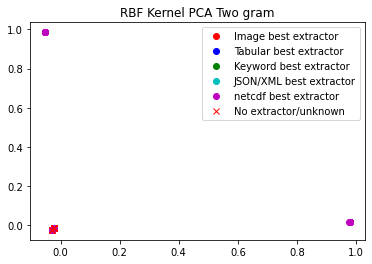

In [ ]:
sc_pca = StandardScaler()
pca = PCA(n_components=2)

pca_after_sc = Pipeline([
    ('std_scaler', sc_pca),
    ('pca', pca),
])

twogram_pca = pca_after_sc.fit_transform(two_grams_total_dataset)

sc_kpca = StandardScaler()
kpca = KernelPCA(n_components=2, kernel='rbf', 
                 gamma=15, random_state=42)

kpca_after_sc = Pipeline([
    ('std_scaler', sc_kpca),
    ('pca', kpca),
])


twogram_kpca = kpca.fit_transform(two_grams_total_dataset)

plot_extractors_against_feature_reduction(all_file_data, twogram_pca, "PCA Two gram")
plot_extractors_against_feature_reduction(all_file_data, twogram_kpca, "RBF Kernel PCA Two gram")

/tmp/ipykernel_2239498/3359898955.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


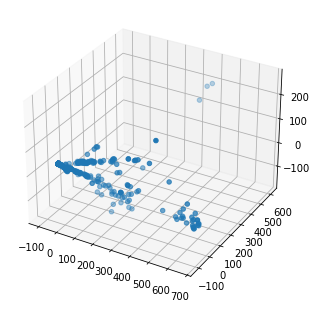

In [ ]:
sc_pca = StandardScaler()
pca_3 = PCA(n_components=3)

pca3_after_sc = Pipeline([('std_scaler', sc_pca), ('pca', pca_3)])

twogram_pca_3 = pca3_after_sc.fit_transform(two_grams_total_dataset)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(twogram_pca_3[:,0], twogram_pca_3[:,1], twogram_pca_3[:,2])
plt.show()

In [ ]:
print(np.sum(pca_3.explained_variance_ratio_))

0.5173449975359611


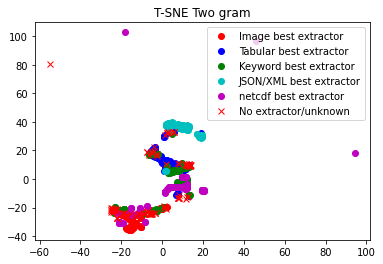

In [ ]:
sc = StandardScaler()
pca = PCA(n_components=50)
tsne = TSNE(n_components=2)

tsne_after_pca = Pipeline([
    ('std_scaler', sc),
    ('pca', pca),
    ('tsne', tsne)
])

two_grams_tsne = tsne_after_pca.fit_transform(two_grams_total_dataset)
plot_extractors_against_feature_reduction(all_file_data, two_grams_tsne, "T-SNE Two gram")

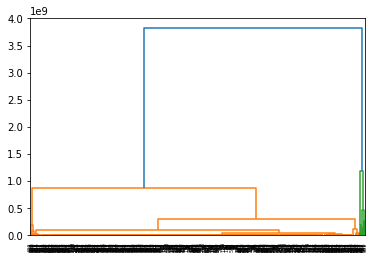

In [ ]:
dendro2gram = sch.dendrogram(sch.linkage(two_grams_total_dataset, method='ward'))

/tmp/ipykernel_2239498/2486539931.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


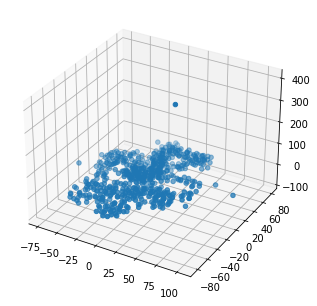

In [ ]:
sc = StandardScaler()
pca = PCA(n_components=50)
tsne = TSNE(n_components=3)

tsne_after_pca = Pipeline([
    ('std_scaler', sc),
    ('pca', pca),
    ('tsne', tsne)
])

twogram_tsne = tsne_after_pca.fit_transform(two_grams_total_dataset)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(twogram_tsne[:,0], twogram_tsne[:,1], twogram_tsne[:,2])
plt.show()

/tmp/ipykernel_2239498/4155999399.py:52: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


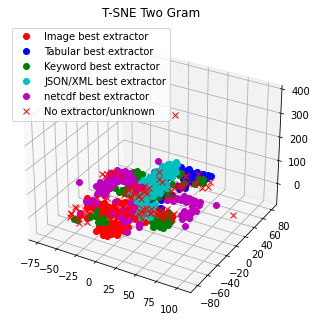

In [ ]:
plot_extractors_against_feature_reduction_3d(all_file_data, twogram_tsne, "T-SNE Two Gram")
